In [5]:
import numpy as np
from numpy.linalg import norm
from math import *
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
import random
from scipy.spatial import ConvexHull
from matplotlib.animation import FuncAnimation
from matplotlib import path
import time
import cv2
from glob import glob
import os
import shutil
from queue import PriorityQueue 
from queue import LifoQueue
%matplotlib inline

<h3><b>The Environment</b></h3>
We created a 5 x 5 Environment for the RRT experiment and planted some obstacles using the Convex Hull function from scipy.spatial. We planted two trapezoidal obstacles in the top and bottom and similar trapezoidal obstacles on the right side. The end point is put in the bottom right corner.

In [6]:
def draw_map(obstacles):
    
    world_bounds_x = [-2.5, 2.5]
    world_bounds_y = [-2.5, 2.5]


    # Draw obstacles
    fig = plt.figure(figsize=(10, 10))
    plt.grid()
    ax = plt.gca()
    ax.set_xlim(world_bounds_x)
    ax.set_ylim(world_bounds_y)
    
    for k in range(len(obstacles)):
        ax.add_patch(Polygon(obstacles[k]))

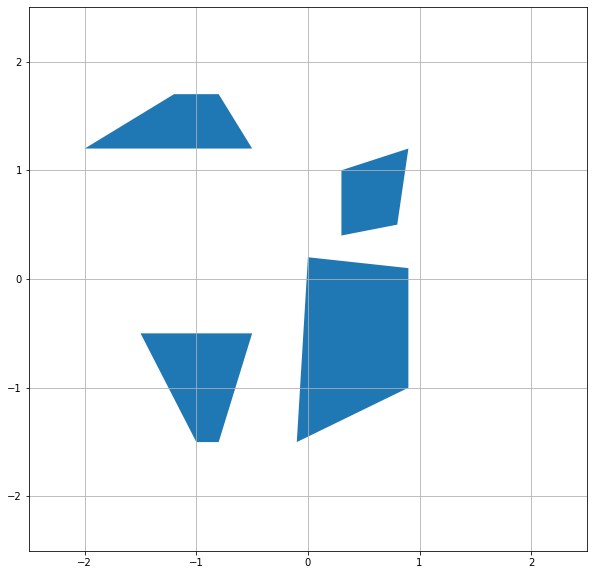

In [7]:
w = 0.2

#Creating arbritarily shaped obstacles

obstacles = [
              np.array([[0.3,0.4], [0.8,0.5], [0.9,1.2], [0.3,1.0]]),
              np.array([[0,0.2],[0.9,0.1],[0.9,-1.0],[-0.1,-1.5]]),
              np.array([[-0.5, -0.5], [-1.5, -0.5], [-1, -1.5], [-0.8, -1.5]]),

              np.array([[-0.5, 1.2], [-2.0, 1.2], [-1-w, 1.5+w], [-0.8, 1.5+w]])
            ]
draw_map(obstacles)

<h2><u>THE ALGORITHM</u></h2>

<h4>The Robot</h4>
For the RRT algorithm, holonomic case, we are using a Differential Drive robot for our experiments that can turn in any direction as and when required.<br>
The Kinematics for the robot are-<br>
If we consider $x_{icc}$ and $y_{icc}$ as the center of the system, then the left and right wheels velocity, which are coupled, will be then coupled together by an angle $\theta$, which the Center of Mass(CoM) makes with the normal, so the subsequent Kinematic equations will be-<br>
<center>$v_x$ = $v_{cm}$*cos($\theta$(t))</center>
<center>$v_y$ = $v_{cm}$*sin($\theta$(t))</center>
Here, $v_{cm}$ denotes the velocity of the center of Mass and the subsequent x and y distances can be obtained by integrating the above equations wrt time, while $\theta(t)$ can be obtained by integrating $\omega$ w.r.t time.

In [8]:
class Node:
    
    def __init__(self):
        self.p     = [0, 0]
        self.i     = 0
        self.iPrev = 0

In [9]:
def closestNode(rrt, p):
    
    #Finds the closest node in the tree to the generated point.
    
    distance = []
    for node in rrt:
        distance.append( sqrt((p[0] - node.p[0]) ** 2 + (p[1] - node.p[1]) ** 2) )
    distance = np.array(distance)

    dmin = min(distance)
    ind_min = distance.tolist().index(dmin)
    closest_node = rrt[ind_min]

    return closest_node

In [10]:
def isCollisionFreeVertex(obstacles, xy):
    
    #Checking if the point has spawned in a valid location
    
    collFree = True

    for obstacle in obstacles:
        hull = path.Path(obstacle)
        collFree = not hull.contains_points([xy])
        if hull.contains_points([xy]):
            return collFree

    return collFree

In [11]:
def isCollisionFreeEdge(obstacles, closest_vert, xy):
    
    #Checking if the line joining closest_vert and xy is free of obstacles or not
    
    closest_vert = np.array(closest_vert); xy = np.array(xy)
    collFree = True
    l = norm(closest_vert - xy)
    map_resolution = 0.01; M = int(l / map_resolution)
    
    if M <= 2: M = 20
    t = np.linspace(0, 1, M)
    
    for i in range(1 ,M-1):
        p = (1 - t[i]) * closest_vert + t[i] * xy
        collFree = isCollisionFreeVertex(obstacles, p) 
        if collFree == False: return False

    return collFree

In [12]:
def start_node(source):
    
    #Creates the source of class Node
    
    start_node = Node()
    start_node.p = source
    start_node.i = 0
    start_node.iPrev = 0 
    return start_node

In [13]:
def get_point(goal):
    #Generates a random point in the grid space
#     rnd = random.random()
#     if rnd < 0.01:
#         #For good convergence, generating a point close to the goal
#         point = np.array([goal[0] + rnd, goal[0] + rnd])
#     elif rnd >= 0.01 and rnd < 0.02:
#         point = np.array([goal[0] + rnd, goal[0] - rnd]) 
#     elif rnd >= 0.02 and rnd < 0.03:
#         point = np.array([goal[0] - rnd, goal[0] - rnd]) 
#     elif rnd >= 0.03 and rnd < 0.04:
#         point = np.array([goal[0] - rnd, goal[0] + rnd]) 
#     else:
    point = np.array([random.random() * 5 - 2.5, random.random() * 5 - 2.5])    
    return point

In [14]:
def get_points_non_holo(exploree, V, dt):
    #Generates a random point in the grid space
    dalpha = np.arange(0,360,1)
    random.shuffle(dalpha)
    alpha_arr = np.array(dalpha[0:10])
    points = []
    for angle in alpha_arr:
        #if angle == 90:
        #    print(angle, exploree)
        if angle != 90:
            Vx = np.array(cos(radians(angle)) * V)
            Vy = np.array(sin(radians(angle)) * V)
            points.append(np.array([exploree[0] + Vx * dt, exploree[1] + Vy * dt]))
    points = np.asarray(points)
    return points

In [26]:
def frames_to_video(input_path, output_path, fps):
    '''
        Function to Concatenate given frames and fps into a video file.
        Input Arguments
        input_path  : Path to the input directory containing input frames
        output_path : Path to the output directory containing the video file
        fps         : Frames per Second of the output video
        Return
        Boolean     : True is Video written successfully, False if writing is not successful.
    '''
    image_files = glob(input_path)
    #print(image_files)    
    
    image_files = glob(input_path)
    final = len(image_files)
    location = "./plots_temp"
    frames = [] 
    for f in range(1, final + 1):
        frame = cv2.imread(f"{location}/{f}.png")
        height, width, channels = frame.shape
        size = (width, height)
        frames.append(frame)

    video_writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
    for frame in frames:
        video_writer.write(frame)

    video_writer.release()
    return True

def frames_to_video_wheel(input_path, output_path, fps):
    '''
        Function to Concatenate given frames and fps into a video file.
        Input Arguments
        input_path  : Path to the input directory containing input frames
        output_path : Path to the output directory containing the video file
        fps         : Frames per Second of the output video
        Return
        Boolean     : True is Video written successfully, False if writing is not successful.
    '''
    image_files = glob(input_path)
    #print(image_files)    
    
    image_files = glob(input_path)
    final = len(image_files)
    location = "./plots_temp_non_holo_wheel"
    print(final)
    frames = [] 
    for f in range(0, final - 1):
        frame = cv2.imread(f"{location}/{10 * f}.png")
        height, width, channels = frame.shape
        size = (width, height)
        frames.append(frame)
        
    frame = cv2.imread(f"{location}/{final - 1}.png")
    height, width, channels = frame.shape
    size = (width, height)
    frames.append(frame)
        
    video_writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
    for frame in frames:
        video_writer.write(frame)

    video_writer.release()
    return True

Number of nodes:  1966


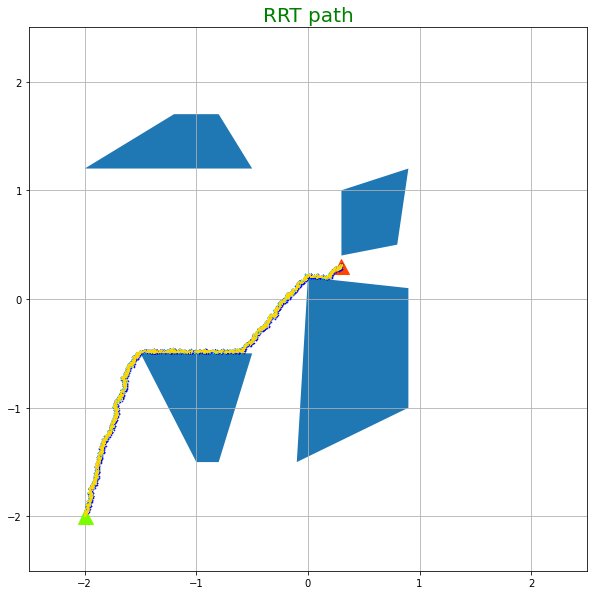

In [16]:
if __name__ == "__main__":
    
    maxiters  = 2000
    nearGoal = False 
    minDistGoal = 0.05
    d = 0.1
    dt = 0.2
    if os.path.isdir("./plots_temp_non_holo"):
        shutil.rmtree("./plots_temp_non_holo")
    os.mkdir("./plots_temp_non_holo")
    
    draw_map(obstacles)
    #stack = LifoQueue()
    xy_start = np.array([0.3, 0.3]); plt.plot(xy_start[0],xy_start[1],'^',color = 'orangered', markersize = 15)
    xy_goal =  np.array([-2.0, -2.0]);  plt.plot(xy_goal[0], xy_goal[1], '^',color = 'lawngreen',markersize = 15)

    rrt = []
    rrt.append(start_node(xy_start))

    #pq = PriorityQueue()
    start_time = time.time()
    iters = 0
    to_explore = Node()
    to_explore.p = xy_start
    to_explore.i = 0
    to_explore.iPrev = 0
    to_explore_update = Node()
    
    while not nearGoal and iters < maxiters:
        iters += 1
        
        sampled_trajectories = get_points_non_holo(to_explore.p, d, dt)
        minDistFromGoal = 10e4
        flag = True
        
        for t in sampled_trajectories:
            if isCollisionFreeEdge(obstacles, to_explore.p, t) and t[0] < 2.5 and t[0] > -2.5 and t[1] < 2.5 and t[1] > -2.5:
            
                dist_from_goal = norm(xy_goal - t)
                flag = False
                to_node = Node()
                to_node.p = t
                to_node.iPrev = to_explore.i
                to_node.i = to_explore.i + 1
                
                if dist_from_goal < minDistFromGoal:
                    minDistFromGoal = dist_from_goal
                    to_explore_update = to_node
                rrt.append(to_node)
                
                if minDistFromGoal < minDistGoal:
                    goal_node = Node()
                    goal_node.p = xy_goal
                    goal_node.i = len(rrt)
                    goal_node.iPrev = to_node.i
                    if isCollisionFreeEdge(obstacles, to_node.p, goal_node.p):
                        rrt.append(goal_node)
                        P = []
                    else: 
                        P = []
                    nearGoal = True
                    
            elif flag:
                to_explore_update = rrt[len(rrt) - 1]
          
            plt.plot(to_node.p[0], to_node.p[1], 'o',color = 'blue', markersize = 0.6)
            plt.plot([to_explore.p[0], to_node.p[0]], [to_explore.p[1], to_node.p[1]], color = 'aqua', linewidth = 0.7)
       
        to_explore = to_explore_update
        plt.savefig("./plots_temp_non_holo/" + str(iters) + ".png")       
       

    plt.title("RRT path", fontsize = 20, color = 'green')
    i = len(rrt) - 1
   
    try:
        for j in range(0,i):
            P.append(rrt[j].p)

        P = np.array(P)
        print('Number of nodes: ', len(rrt))
        #print(f"Number of nodes on the RRT path: {P.shape[0]}")
        plt.plot(P[:,0],P[:,1], color = 'gold', linewidth = 0.5 )
        
    except:
        print(f"The Rapid Exploring Random Tree algorithm wasn't able to converge in {maxiters} iterations")

    finally:
        frames_to_video("./plots_temp_non_holo/*.png", "./non_holonomic_path.mp4", 24)

Keypoints of the algorithm and the non-holonomic constraitn in action-
<h3>The Starting of the Non-holonomic RRT and Encounter the first obstacle</h3>
<img src = "Non-holo1.jpeg">

<h3>The Robot continues its path towards goal by skating the obstacle</h3>
<img src = "Non-holo2.jpeg">

<h3>The Robot explores straight towards Goal</h3>
<img src = "Non-holo3.jpeg">

<h3>The Robot skates the second Obstacle</h3>
<img src = "Non-holo4.jpeg">

In [23]:
def get_gradient(point1, point2):
    x1 = point1[0]; y1 = point1[1]
    x2 = point2[0]; y2 = point2[1]
    if x2 - x1 == 0:
        return 10e4
    return (y2 - y1) / (x2 - x1)

def get_angle(m1, m2):
    return atan((m1 - m2) / (1 + m1 * m2))


if os.path.isdir("./plots_temp_non_holo_wheel"):
    shutil.rmtree("./plots_temp_non_holo_wheel")
os.mkdir("./plots_temp_non_holo_wheel")
print(len(P))

1965


KeyboardInterrupt: 

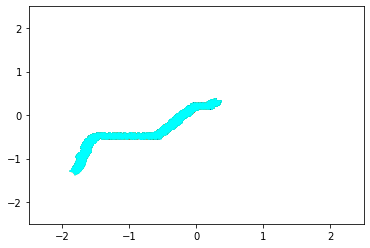

In [24]:
x = []
y = []
y_l = []
x_l = []
x_r = []
y_r = []
d = 0.05
for num, r in enumerate(P):
    x.append(r[0])
    y.append(r[1])
    P_0 = np.array([r[0], r[1]])
    P_1 = np.array([r[0], r[1]])
    P_2 = np.array([r[0], r[1]])

    if num == 0:
        P_0 = np.array([r[0], r[1] - 1])
        P_1 = np.array([r[0], r[1]])
        P_2 = np.array([P[num + 1][0], P[num + 1][1]])
    if num == len(P) - 1:
        pass
    else:
        P_0 = np.array([P[num - 1][0], P[num - 1][1]])
        P_1 = np.array([r[0], r[1]])
        P_2 = np.array([P[num + 1][0], P[num + 1][1]])
        
    m1 = get_gradient(P_0, P_1)
    m2 = get_gradient(P_1, P_2)
    
    rad_rot = get_angle(m1, m2)
    
    if degrees(rad_rot) >= 0:
        y_l.append(r[1] + d * sin(rad_rot))
        x_l.append(r[0] - d * cos(rad_rot))
        y_r.append(r[1] - d * sin(rad_rot))
        x_r.append(r[0] + d * cos(rad_rot))
    else:
        y_r.append(r[1] - d * sin(rad_rot))
        x_r.append(r[0] - d * cos(rad_rot))
        y_l.append(r[1] + d * sin(rad_rot))
        x_l.append(r[0] + d * cos(rad_rot))

    if num % 10 == 0 or num == len(P) - 1:
        xNum = np.array(x)
        yNum = np.array(y)
        x_rNum = np.array(x_r)
        y_rNum = np.array(y_r)
        x_lNum = np.array(x_l)
        y_lNum = np.array(y_l)
        #plt.figure(figsize = (20,20))
        plt.xlim([-2.5, 2.5])
        plt.ylim([-2.5, 2.5])
        plt.plot(xNum, yNum, label = "ICC")
        plt.plot(x_lNum, y_lNum, label = "left wheel")
        plt.plot(x_rNum, y_rNum, label = "right wheel")
        plt.plot([x_lNum, x_rNum], [y_lNum, y_rNum], color = 'aqua')
        #plt.legend()
        plt.savefig("./plots_temp_non_holo_wheel/" + str(num) + ".png")


In [27]:
frames_to_video_wheel("./plots_temp_non_holo_wheel/*.png", "./non_holonomic_wheel_path.mp4", 12)

161


True